In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from PIL import Image

In [ ]:
!unzip /content/train_data.zip
!unzip /content/test_data.zip

# Xem trước ảnh để biết kích thước

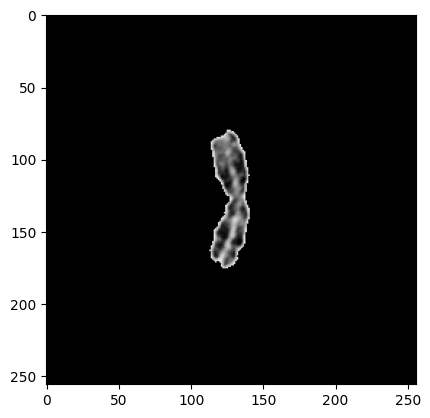

In [3]:
path = "/content/final/single_chromosome/1/97002023.16.tiff_33652998_1.tiff"
image = cv2.imread(path)
plt.imshow(image, cmap = "gray")

In [4]:
image.shape

(256, 256, 3)

Như vậy ảnh là ảnh kích thước (256, 256) có 3 kênh với định dạng TIFF

# Tạo training set, validation set và test set

ảnh chỉ có 3 kênh, do đó có thể chuyển sang định dạng PNG mà không mất thông tin

In [11]:
def convert_tiff_to_png(root_dir_str):
    root_path = Path(root_dir_str)

    print(f"Bắt đầu quét thư mục: {root_path}")
    converted_count = 0
    error_count = 0

    # Duyệt qua các mục trong thư mục gốc
    # root_path.iterdir() trả về một iterator các đối tượng Path
    for item in root_path.iterdir():
        if item.is_dir():  # Chỉ xử lý nếu là thư mục con
            subfolder_path = item
            print(f"\nĐang xử lý thư mục con: {subfolder_path}")

            # Duyệt qua các tệp trong thư mục con
            for file_path in subfolder_path.iterdir():
                if file_path.is_file(): # Chỉ xử lý nếu là tệp tin
                    # file_path.suffix trả về phần mở rộng có dấu chấm (ví dụ: '.tif')
                    # file_path.stem trả về tên tệp không có phần mở rộng
                    if file_path.suffix.lower() in ['.tif', '.tiff']:
                        tiff_file_path = file_path
                        # Tạo đường dẫn PNG mới bằng cách thay đổi phần mở rộng
                        png_file_path = tiff_file_path.with_suffix(".png")


                        # Mở ảnh TIFF (Pillow chấp nhận đối tượng Path)
                        with Image.open(tiff_file_path) as img:
                            # Lưu ảnh dưới dạng PNG (Pillow chấp nhận đối tượng Path)
                            img.save(png_file_path, "PNG")
                        print(f"  Đã chuyển đổi: {tiff_file_path} -> {png_file_path}")
                        converted_count += 1


                        tiff_file_path.unlink() # Xóa tệp bằng pathlib
                        print(f"  Đã xóa tệp gốc: {tiff_file_path}")
        else:
            print(f"Bỏ qua (không phải thư mục): {item}")

    print(f"\nHoàn tất quá trình.")
    print(f"Tổng số tệp đã chuyển đổi thành công: {converted_count}")
    print(f"Tổng số tệp gặp lỗi: {error_count}")

In [4]:
training_path = "/content/final/single_chromosome"
test_path = "/content/single_chromosome"

In [ ]:
convert_tiff_to_png(training_path)

In [ ]:
convert_tiff_to_png(test_path)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(training_path),
    labels = "inferred",
    label_mode = "int",
    image_size= (256,256),
    color_mode = 'rgb',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    validation_split = 0.1,
    subset = "training"
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(training_path),
    labels = "inferred",
    label_mode = "int",
    image_size= (256,256),
    color_mode = 'rgb',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    validation_split = 0.1,
    subset = "validation"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(test_path),
    seed = 42,
    labels = "inferred",
    label_mode = "int",
    image_size = (256,256),
    color_mode = 'rgb'
)

Found 25299 files belonging to 24 classes.
Using 22770 files for training.
Found 25299 files belonging to 24 classes.
Using 2529 files for validation.
Found 2801 files belonging to 24 classes.


# Trực quan hoá dữ liệu

In [6]:
class_names = train_ds.class_names
class_names

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

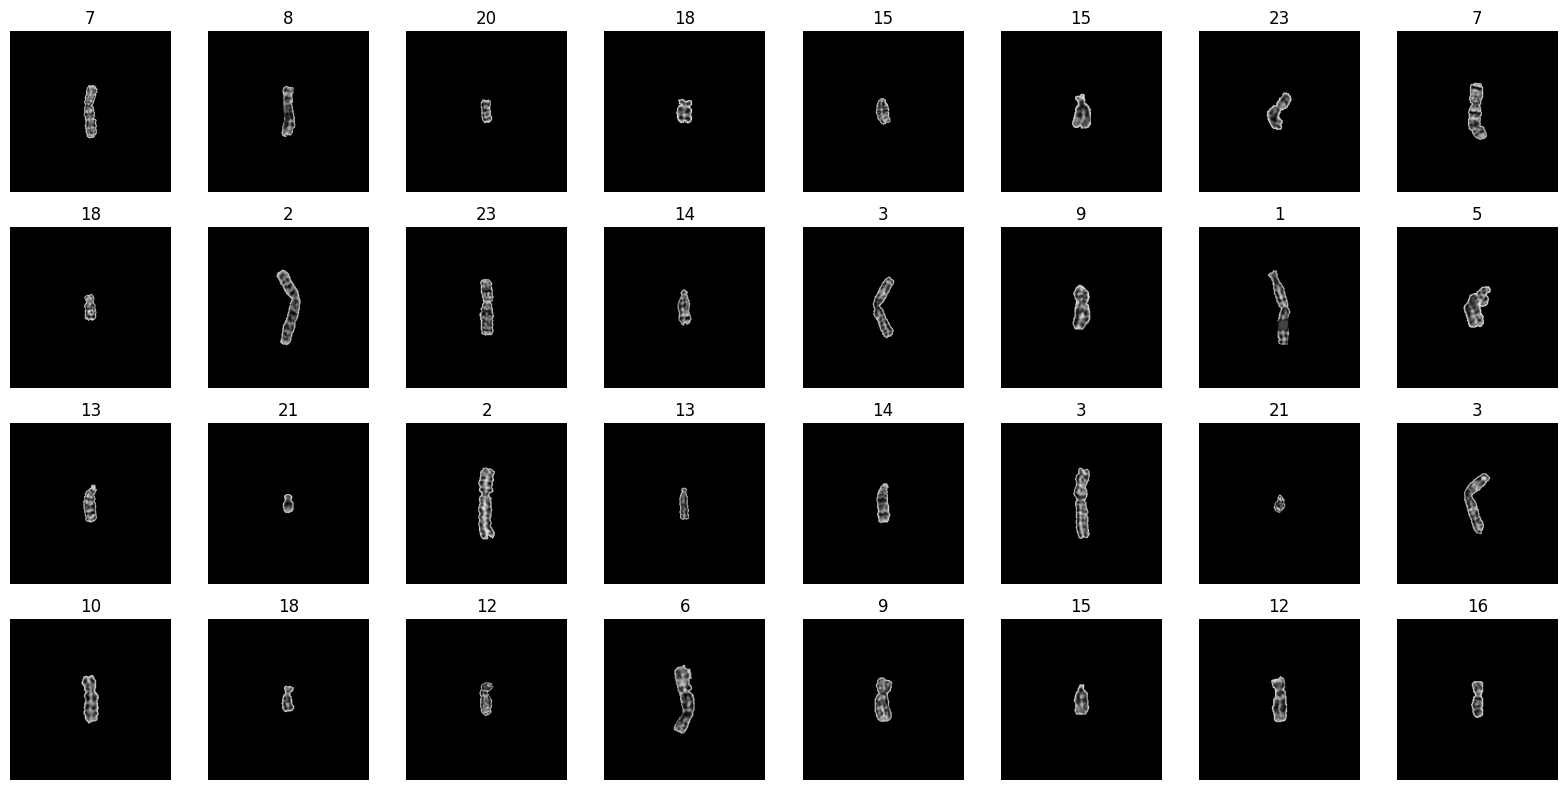

In [7]:
n_row = 4
n_col = 8
plt.figure(figsize=(16,8))

for images, labels in train_ds.take(1):
  for i in range(32):
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
for image_batch, labels_batch in train_ds.take(1):
    max_val = tf.reduce_max(image_batch).numpy()
    min_val = tf.reduce_min(image_batch).numpy()

    print(f"Giá trị pixel lớn nhất trong batch: {max_val}")
    print(f"Giá trị pixel nhỏ nhất trong batch: {min_val}")

Giá trị pixel lớn nhất trong batch: 249.0
Giá trị pixel nhỏ nhất trong batch: 0.0


# Chuẩn hoá

In [10]:
normalizer_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
train_ds = train_ds.map(lambda X, y: (normalizer_layer(X),y))
valid_ds = valid_ds.map(lambda X, y: (normalizer_layer(X),y))
test_ds = test_ds.map(lambda X, y: (normalizer_layer(X),y))

In [33]:
for image_batch, _ in valid_ds.take(1):
  max_pixel = tf.reduce_max(image_batch).numpy()
  min_pixel = tf.reduce_min(image_batch).numpy()

  print("Giá trị pixel lớn nhất là: ", max_pixel)
  print("Giá trị pixel nhỏ nhất là: ", min_pixel)

Giá trị pixel lớn nhất là:  0.97647065
Giá trị pixel nhỏ nhất là:  0.0


In [13]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Xây dựng mô hình

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (256,256,3)),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, 4, padding = 'same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(24, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    13,107,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,261,212 (50.59 MB)

 Trainable params: 13,260,764 (50.59 MB)

 Non-trainable params: 448 (1.75 KB)

# Tìm learning rate hợp lý

In [42]:
model_clone = tf.keras.models.clone_model(model)

In [16]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor =  factor
    self.rates = []
    self.losses = []

  def on_batch_end(self, batch, logs = None):
    lr = self.model.optimizer.learning_rate.numpy() * self.factor
    self.model.optimizer.learning_rate = lr
    self.rates.append(lr)
    self.losses.append(logs['loss'])

  def plot(self):
    plt.plot(self.rates, self.losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(self.losses), min(self.rates), max(self.rates))
    plt.axis([min(self.rates), max(self.rates), 0, 20])
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
expon_lr = ExponentialLearningRate(factor = 1.005)
model_clone.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])

In [44]:
model_clone.fit(train_ds, epochs = 3, validation_data=(valid_ds), callbacks=[expon_lr])

Epoch 1/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 73s 91ms/step - accuracy: 0.0933 - loss: 3.4323 - val_accuracy: 0.2681 - val_loss: 2.3403
Epoch 2/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 60s 85ms/step - accuracy: 0.2724 - loss: 2.1272 - val_accuracy: 0.5223 - val_loss: 1.4680
Epoch 3/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.5959 - loss: 1.2210 - val_accuracy: 0.5678 - val_loss: 1.3531


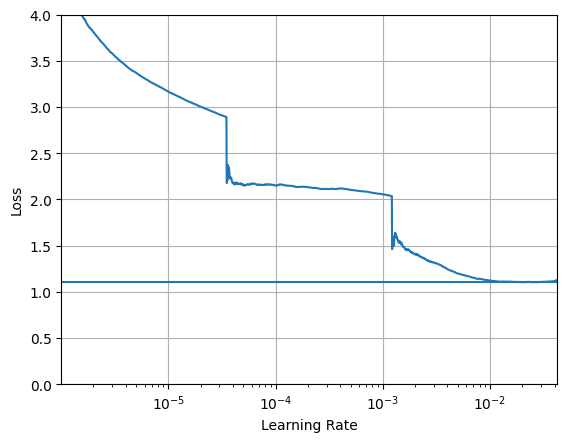

In [45]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0,4])
plt.grid()
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

# Huấn luyện mô hình

In [54]:
tf.keras.backend.clear_session()

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics= ['accuracy'])

In [56]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("bestModel.keras", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.2, patience = 3, min_lr=1e-6)

In [57]:
history = model.fit(train_ds, epochs = 100, validation_data=(valid_ds), callbacks = [model_checkpoint,early_stopping,reduceLR])

Epoch 1/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 71s 92ms/step - accuracy: 0.0552 - loss: 7.0353 - val_accuracy: 0.0886 - val_loss: 2.9714 - learning_rate: 0.0020
Epoch 2/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.0981 - loss: 2.8598 - val_accuracy: 0.1582 - val_loss: 2.5625 - learning_rate: 0.0020
Epoch 3/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.1353 - loss: 2.5587 - val_accuracy: 0.1677 - val_loss: 2.4666 - learning_rate: 0.0020
Epoch 4/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.1469 - loss: 2.4399 - val_accuracy: 0.1775 - val_loss: 2.3727 - learning_rate: 0.0020
Epoch 5/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 58s 82ms/step - accuracy: 0.1516 - loss: 2.3755 - val_accuracy: 0.1807 - val_loss: 2.3082 - learning_rate: 0.0020
Epoch 6/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.1617 - loss: 2.3116 - val_accuracy: 0.1767 - val_loss: 2.2868 - learning_rate: 0.0020
Epoch 7/100
712/712 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - accuracy: 0.1

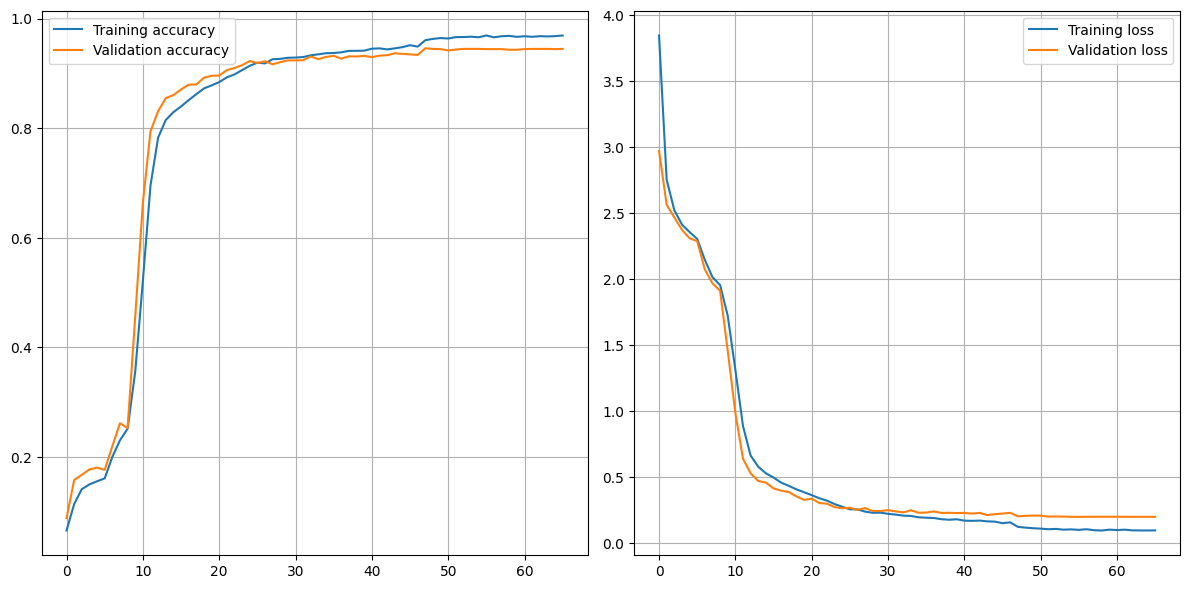

In [58]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label = "Training accuracy")
plt.plot(epochs, val_acc, label = "Validation accuracy" )
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, label = "Training loss")
plt.plot(epochs, val_loss, label = "Validation loss" )
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Đánh giá trên test set

In [59]:
model = tf.keras.models.load_model("bestModel.keras")
model.evaluate(test_ds)

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9266 - loss: 0.3287


[0.31016144156455994, 0.9300249814987183]